In [1]:
!pip -q install ultralytics roboflow opencv-python pillow

In [2]:
import os
import shutil
from roboflow import Roboflow
from ultralytics import YOLO
import random
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
rf = Roboflow(api_key="RYhIPZ52cOVyti3f7sns")

datasets_info = [{"workspace": "rashad-pcyex", "project": "airbus_tiles", "version": 1},
                 {"workspace": "aircrafts", "project": "airbus-pleiades", "version": 1},]

combined_path = "datasets/combined"

def merge_datasets(datasets_info, combined_path):
    for dataset_info in datasets_info:
        # Download dataset
        workspace = dataset_info["workspace"]
        project = dataset_info["project"]
        version = dataset_info["version"]

        project_data = rf.workspace(workspace).project(project)
        dataset = project_data.version(version).download("yolov8")

        # Merge folders
        for split in ["train", "valid", "test"]:
            src_path = os.path.join(dataset.location, split)
            dst_path = os.path.join(combined_path, split)
            os.makedirs(dst_path, exist_ok=True)

            if os.path.exists(src_path):
                for file_type in ["images", "labels"]:
                    src_subpath = os.path.join(src_path, file_type)
                    dst_subpath = os.path.join(dst_path, file_type)
                    os.makedirs(dst_subpath, exist_ok=True)

                    for file in os.listdir(src_subpath):
                        shutil.copy(os.path.join(src_subpath, file), dst_subpath)

In [4]:
merge_datasets(datasets_info, combined_path)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to airbus_tiles-1 in yolov8:: 100%|██████████| 9474/9474 [00:01<00:00, 8856.76it/s]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Airbus-Pleiades-1 in yolov8:: 100%|██████████| 9142/9142 [00:00<00:00, 9467.49it/s] 


In [5]:
def rename_class_labels(dataset_path, old_class_name, new_class_id):
    labels_dir = os.path.join(dataset_path, "labels")

    for split in ["train", "valid", "test"]:
        split_path = os.path.join(labels_dir, split)
        if not os.path.exists(split_path):
            continue

        for label_file in os.listdir(split_path):
            file_path = os.path.join(split_path, label_file)

            with open(file_path, "r") as file:
                lines = file.readlines()

            updated_lines = []
            for line in lines:
                parts = line.strip().split()
                if parts[0] == old_class_name:
                    parts[0] = str(new_class_id)
                updated_lines.append(" ".join(parts))

            with open(file_path, "w") as file:
                file.write("\n".join(updated_lines))

In [6]:
rename_class_labels("datasets/combined/train", old_class_name="aircraft", new_class_id=0)
rename_class_labels("datasets/combined/valid", old_class_name="aircraft", new_class_id=0)

In [7]:
def visualize_random_sample(dataset_path, split="train"):
    images_path = os.path.join(dataset_path, split, "images")
    labels_path = os.path.join(dataset_path, split, "labels")
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]
    selected_image = random.choice(image_files)
    image_path = os.path.join(images_path, selected_image)
    label_path = os.path.join(labels_path, selected_image.replace(".jpg", ".txt").replace(".png", ".txt"))
    image = Image.open(image_path)
    with open(label_path, "r") as f:
        labels = f.readlines()
        
    plt.imshow(image)
    for label in labels:
        cls, x, y, w, h = map(float, label.split())
        x_center, y_center = x * image.width, y * image.height
        width, height = w * image.width, h * image.height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        rect = plt.Rectangle(
            (x_min, y_min), width, height, linewidth=1, edgecolor="r", facecolor="none"
        )
        plt.gca().add_patch(rect)
        plt.text(x_min, y_min, f"Class {int(cls)}", color="white", backgroundcolor="red")
    
    plt.title(f"Sample: {selected_image}")
    plt.axis("off")
    plt.show()

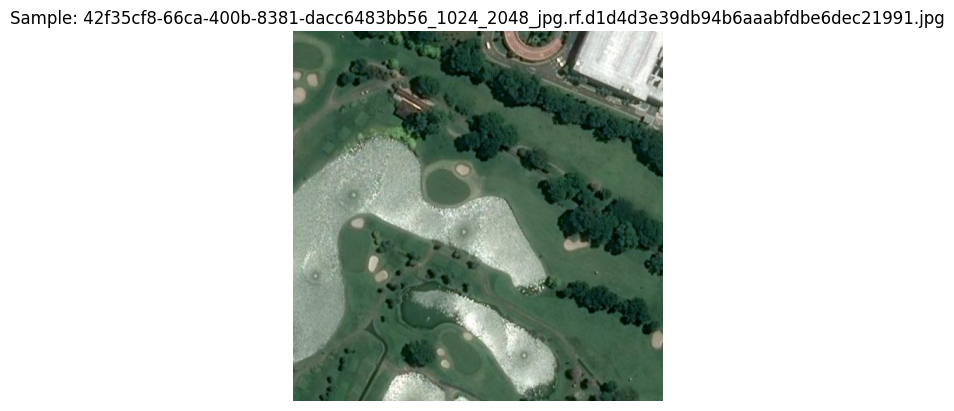

In [8]:
visualize_random_sample("datasets/combined", split="valid")

In [9]:
data_yaml_content = """
train: combined/train/images
val: combined/valid/images
test: combined/test/images

nc: 1
names: ['aircraft']
"""
with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [10]:
model = YOLO('yolov8s.pt')  #  'yolov8n.pt' 'yolov8s.pt', 'yolov8m.pt' for larger models
model.train(data="data.yaml", epochs=20, batch=16, imgsz=960)
model.save("model_last.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 112MB/s] 


Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=960, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None,

100%|██████████| 755k/755k [00:00<00:00, 27.5MB/s]
2024-12-02 17:41:16,007	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-02 17:41:17,351	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 112MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/combined/train/labels... 7928 images, 793 backgrounds, 0 corrupt: 100%|██████████| 7928/7928 [00:06<00:00, 1183.48it/s]


train: New cache created: /kaggle/working/datasets/combined/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/datasets/combined/valid/labels... 917 images, 236 backgrounds, 0 corrupt: 100%|██████████| 917/917 [00:00<00:00, 1261.97it/s]

val: New cache created: /kaggle/working/datasets/combined/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 960 train, 960 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      8.74G     0.9427      1.016      1.173         28        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:14<00:00,  2.03it/s]

                   all        917       1951      0.934      0.828      0.893      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      8.63G     0.9335     0.6882      1.177         50        960: 100%|██████████| 496/496 [04:28<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

                   all        917       1951      0.901      0.779      0.854      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      8.69G      0.909     0.6351      1.151         24        960: 100%|██████████| 496/496 [04:27<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.17it/s]

                   all        917       1951      0.947       0.83      0.885      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      8.65G     0.8812     0.5915      1.138         32        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all        917       1951      0.935      0.887      0.919      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       8.6G     0.8381     0.5366      1.113         24        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.20it/s]

                   all        917       1951      0.937      0.838      0.892      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      8.57G     0.8043     0.5043      1.095         36        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all        917       1951      0.948      0.885      0.925       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      8.63G     0.7896     0.4783      1.085         32        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all        917       1951      0.959      0.883      0.926      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      8.58G     0.7713     0.4605      1.073         50        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all        917       1951      0.967      0.881      0.928      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      8.65G     0.7459     0.4392      1.064         15        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all        917       1951      0.964      0.885      0.933      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      8.64G     0.7315     0.4193      1.056         47        960: 100%|██████████| 496/496 [04:26<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.20it/s]

                   all        917       1951       0.97      0.892      0.935       0.67


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      8.59G     0.7253     0.3847      1.062         12        960: 100%|██████████| 496/496 [04:25<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all        917       1951      0.967      0.895      0.936      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      8.64G     0.7148     0.3804      1.054         17        960: 100%|██████████| 496/496 [04:23<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.20it/s]

                   all        917       1951      0.969      0.883      0.936      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       8.6G     0.6981     0.3638      1.048         11        960: 100%|██████████| 496/496 [04:23<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all        917       1951      0.961      0.906      0.938      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      8.58G     0.6848     0.3499      1.044         18        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.21it/s]

                   all        917       1951      0.967      0.904      0.941      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      8.58G     0.6707     0.3365      1.029         11        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all        917       1951       0.96      0.905      0.939      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      8.58G     0.6564     0.3286      1.021         14        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

                   all        917       1951      0.955      0.913      0.945       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      8.57G     0.6441     0.3215      1.012         12        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.19it/s]

                   all        917       1951      0.968      0.904      0.943      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      8.59G     0.6301     0.3046      1.004         13        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.18it/s]

                   all        917       1951      0.974      0.903      0.945      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      8.59G     0.6151     0.2979     0.9914         16        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

                   all        917       1951      0.974       0.91      0.948      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      8.58G     0.5988     0.2871     0.9961         20        960: 100%|██████████| 496/496 [04:24<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.22it/s]

                   all        917       1951      0.976      0.908      0.945       0.73



20 epochs completed in 1.555 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:13<00:00,  2.07it/s]


                   all        917       1951      0.976      0.908      0.945       0.73
Speed: 0.4ms preprocess, 10.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


In [11]:
metrics = model.val()
print(metrics)

Ultralytics 8.3.40 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/datasets/combined/valid/labels.cache... 917 images, 236 backgrounds, 0 corrupt: 100%|██████████| 917/917 [00:00<?, ?it/s]
os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:22<00:00,  2.54it/s]


                   all        917       1951      0.976      0.908      0.945       0.73
Speed: 0.5ms preprocess, 20.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f6bc9b37f40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03

In [12]:
results = model.predict(source="datasets/combined/test/images", save=True)


image 1/451 /kaggle/working/datasets/combined/test/images/014de911-7810-4f7d-8967-3e5402209f4a_0_0_jpg.rf.f6bfdddd6f444def870dd57d003206cd.jpg: 960x960 (no detections), 30.0ms
image 2/451 /kaggle/working/datasets/combined/test/images/014de911-7810-4f7d-8967-3e5402209f4a_1472_2048_jpg.rf.63b65e08f70c26d0c394050d02dd8c13.jpg: 960x960 2 aircrafts, 30.0ms
image 3/451 /kaggle/working/datasets/combined/test/images/014de911-7810-4f7d-8967-3e5402209f4a_1536_1024_jpg.rf.2f865c90ddb8dd2234ca2ceddf515c96.jpg: 960x960 1 aircraft, 30.0ms
image 4/451 /kaggle/working/datasets/combined/test/images/014de911-7810-4f7d-8967-3e5402209f4a_2048_0_jpg.rf.f9d9d5d4b6c447a4ec171456aec04821.jpg: 960x960 5 aircrafts, 30.0ms
image 5/451 /kaggle/working/datasets/combined/test/images/0263270b-e3ee-41dc-aeef-43ff77e66d5b_1472_1472_jpg.rf.ae38df60b88d41df7f506895192cf27a.jpg: 960x960 1 aircraft, 21.4ms
image 6/451 /kaggle/working/datasets/combined/test/images/0263270b-e3ee-41dc-aeef-43ff77e66d5b_1472_448_jpg.rf.d3502

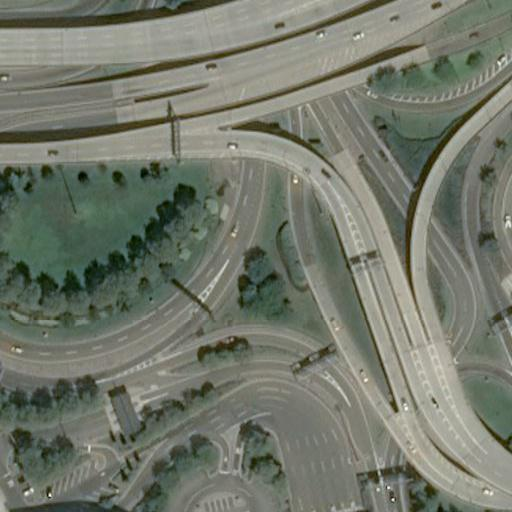

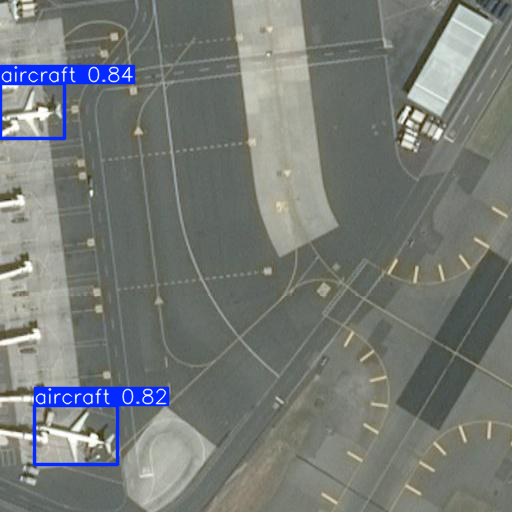

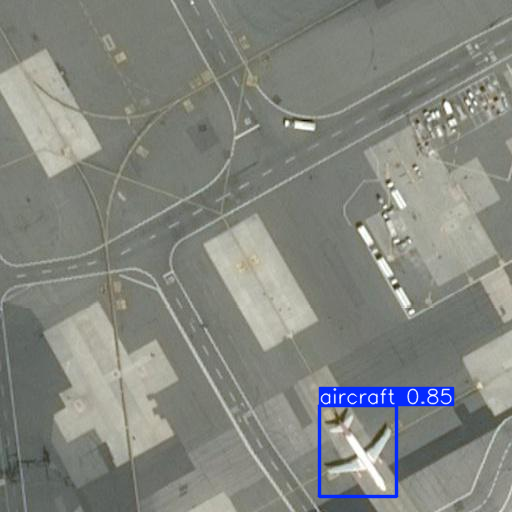

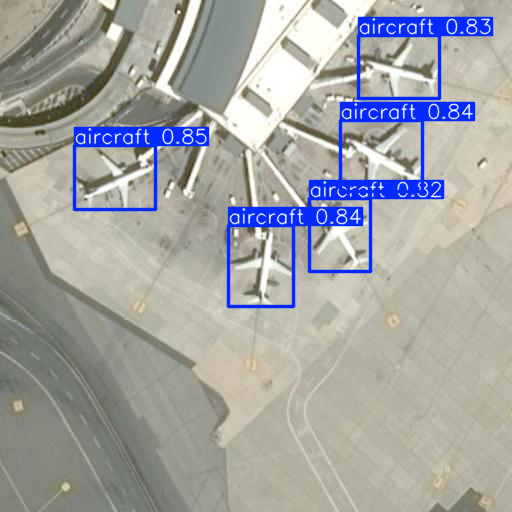

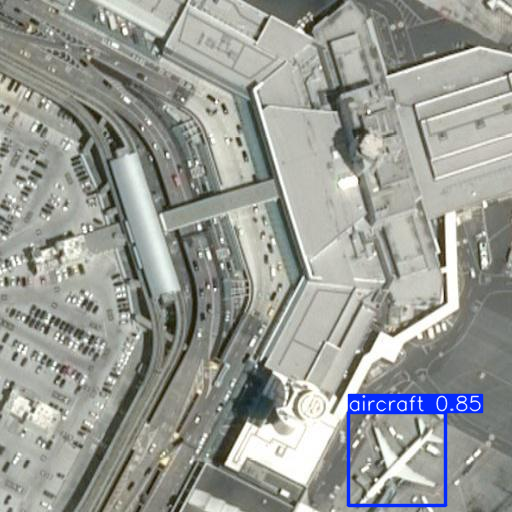

In [13]:
for result in results[:5]:
    result.show()

In [14]:
def sliding_window(image, window_size=(800, 600), margin=(2000, 2000, 500, 500)):
    windows = []
    h, w = image.shape[:2]
    left_margin, right_margin, top_margin, bottom_margin = margin
    window_width, window_height = window_size

    for y in range(top_margin, h - window_height - bottom_margin + 1, window_height):
        for x in range(left_margin, w - window_width - right_margin + 1, window_width):
            window = image[y:y + window_height, x:x + window_width]
            windows.append((window, (x, y)))
    
    return windows

In [15]:
def sliding_window(image, step_size=640, window_size=(640, 640)):
    windows = []
    for y in range(0, image.shape[0] - window_size[1], step_size):  # Sliding vertically
        for x in range(0, image.shape[1] - window_size[0], step_size):  # Sliding horizontally
            window = image[y:y + window_size[1], x:x + window_size[0]]
            windows.append((window, (x, y)))  # Store the window and its position
    return windows

In [16]:
image_path = "/kaggle/input/photoair/Cairo_Airport_2.tif"
image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
windows = sliding_window(image)

  0%|          | 0/912 [00:00<?, ?it/s]


0: 960x960 (no detections), 30.1ms
Speed: 5.5ms preprocess, 30.1ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)


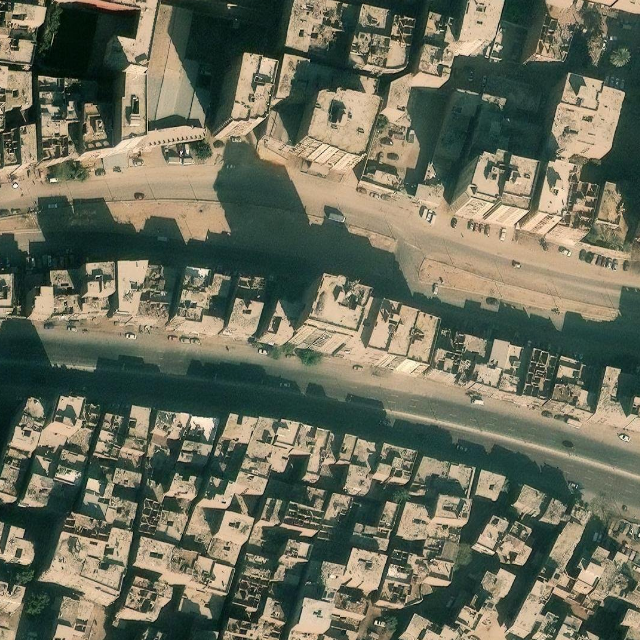

  0%|          | 1/912 [00:00<01:56,  7.83it/s]


0: 960x960 1 aircraft, 30.1ms
Speed: 4.8ms preprocess, 30.1ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 30.0ms
Speed: 4.5ms preprocess, 30.0ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 30.0ms
Speed: 5.6ms preprocess, 30.0ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)


  0%|          | 4/912 [00:00<00:51, 17.71it/s]


0: 960x960 (no detections), 30.0ms
Speed: 6.1ms preprocess, 30.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 30.0ms
Speed: 5.1ms preprocess, 30.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 30.0ms
Speed: 5.0ms preprocess, 30.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  1%|          | 7/912 [00:00<00:42, 21.16it/s]


0: 960x960 (no detections), 20.0ms
Speed: 5.0ms preprocess, 20.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.7ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  1%|          | 11/912 [00:00<00:33, 26.93it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.6ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.1ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  2%|▏         | 15/912 [00:00<00:29, 30.55it/s]


0: 960x960 (no detections), 17.8ms
Speed: 5.2ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.4ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.6ms
Speed: 4.5ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  2%|▏         | 19/912 [00:00<00:26, 33.21it/s]


0: 960x960 (no detections), 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  3%|▎         | 23/912 [00:00<00:25, 35.07it/s]


0: 960x960 (no detections), 18.3ms
Speed: 5.0ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.7ms
Speed: 4.5ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  3%|▎         | 27/912 [00:00<00:24, 36.29it/s]


0: 960x960 2 aircrafts, 18.7ms
Speed: 4.8ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.1ms preprocess, 17.7ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.2ms
Speed: 4.7ms preprocess, 19.2ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


  3%|▎         | 31/912 [00:00<00:24, 36.48it/s]


0: 960x960 (no detections), 17.7ms
Speed: 4.7ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.6ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.5ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  4%|▍         | 35/912 [00:01<00:23, 37.20it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 5.1ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.6ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  4%|▍         | 39/912 [00:01<00:23, 37.68it/s]


0: 960x960 (no detections), 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.8ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.7ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.9ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  5%|▍         | 43/912 [00:01<00:22, 37.84it/s]


0: 960x960 (no detections), 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 5.6ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.6ms
Speed: 5.5ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  5%|▌         | 47/912 [00:01<00:22, 37.92it/s]


0: 960x960 (no detections), 18.4ms
Speed: 5.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.4ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 4.5ms preprocess, 17.3ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)


  6%|▌         | 51/912 [00:01<00:22, 38.24it/s]


0: 960x960 (no detections), 19.1ms
Speed: 5.3ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 5.1ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  6%|▌         | 55/912 [00:01<00:22, 38.17it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.4ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  6%|▋         | 59/912 [00:01<00:22, 38.37it/s]


0: 960x960 (no detections), 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 6 aircrafts, 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.8ms
Speed: 4.6ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.3ms
Speed: 4.4ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


  7%|▋         | 63/912 [00:01<00:22, 38.09it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.6ms
Speed: 4.7ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  7%|▋         | 67/912 [00:01<00:22, 38.22it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.7ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.2ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.4ms
Speed: 5.1ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.4ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  8%|▊         | 71/912 [00:02<00:22, 38.22it/s]


0: 960x960 (no detections), 17.1ms
Speed: 4.6ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.6ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  8%|▊         | 75/912 [00:02<00:21, 38.46it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.8ms preprocess, 18.4ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  9%|▊         | 79/912 [00:02<00:21, 38.52it/s]


0: 960x960 (no detections), 18.9ms
Speed: 4.4ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


  9%|▉         | 83/912 [00:02<00:21, 38.51it/s]


0: 960x960 (no detections), 18.2ms
Speed: 5.2ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.7ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 10%|▉         | 87/912 [00:02<00:21, 38.58it/s]


0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.9ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 10%|▉         | 91/912 [00:02<00:21, 38.53it/s]


0: 960x960 (no detections), 17.3ms
Speed: 5.2ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 10%|█         | 95/912 [00:02<00:21, 38.63it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 4 aircrafts, 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 11%|█         | 99/912 [00:02<00:21, 38.47it/s]


0: 960x960 (no detections), 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.8ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.5ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 4.8ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 11%|█▏        | 103/912 [00:02<00:20, 38.54it/s]


0: 960x960 1 aircraft, 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.2ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.8ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.7ms
Speed: 4.4ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 12%|█▏        | 107/912 [00:02<00:20, 38.45it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.9ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 12%|█▏        | 111/912 [00:03<00:20, 38.63it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.4ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 13%|█▎        | 115/912 [00:03<00:20, 38.53it/s]


0: 960x960 (no detections), 18.5ms
Speed: 4.6ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 13%|█▎        | 119/912 [00:03<00:20, 38.59it/s]


0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 5.0ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 13%|█▎        | 123/912 [00:03<00:20, 38.60it/s]


0: 960x960 (no detections), 17.9ms
Speed: 4.9ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.6ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.0ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 14%|█▍        | 127/912 [00:03<00:20, 38.58it/s]


0: 960x960 (no detections), 17.2ms
Speed: 4.6ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 14%|█▍        | 131/912 [00:03<00:20, 38.69it/s]


0: 960x960 (no detections), 17.4ms
Speed: 5.3ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 5 aircrafts, 18.4ms
Speed: 4.7ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.1ms
Speed: 5.1ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 15%|█▍        | 135/912 [00:03<00:20, 38.43it/s]


0: 960x960 (no detections), 16.6ms
Speed: 5.2ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 4 aircrafts, 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.0ms
Speed: 4.4ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.1ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 15%|█▌        | 139/912 [00:03<00:20, 38.28it/s]


0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)


 16%|█▌        | 143/912 [00:03<00:19, 38.48it/s]


0: 960x960 (no detections), 18.5ms
Speed: 5.2ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.0ms
Speed: 5.2ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 16%|█▌        | 147/912 [00:04<00:19, 38.25it/s]


0: 960x960 1 aircraft, 18.2ms
Speed: 5.2ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 17%|█▋        | 151/912 [00:04<00:19, 38.08it/s]


0: 960x960 (no detections), 17.3ms
Speed: 4.4ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 17%|█▋        | 155/912 [00:04<00:19, 38.31it/s]


0: 960x960 1 aircraft, 16.8ms
Speed: 4.4ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 17%|█▋        | 159/912 [00:04<00:19, 38.47it/s]


0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 18%|█▊        | 163/912 [00:04<00:19, 38.57it/s]


0: 960x960 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 18%|█▊        | 167/912 [00:04<00:19, 38.67it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.4ms
Speed: 5.1ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 19%|█▉        | 171/912 [00:04<00:19, 38.21it/s]


0: 960x960 (no detections), 18.3ms
Speed: 5.0ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 5 aircrafts, 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 6 aircrafts, 18.3ms
Speed: 4.9ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 19%|█▉        | 175/912 [00:04<00:19, 37.97it/s]


0: 960x960 4 aircrafts, 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.3ms
Speed: 4.9ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.6ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 20%|█▉        | 179/912 [00:04<00:19, 37.97it/s]


0: 960x960 (no detections), 16.7ms
Speed: 4.4ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.5ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)


 20%|██        | 183/912 [00:04<00:19, 38.06it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 21%|██        | 187/912 [00:05<00:18, 38.24it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 21%|██        | 191/912 [00:05<00:18, 38.48it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.6ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 21%|██▏       | 195/912 [00:05<00:18, 38.41it/s]


0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.9ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 22%|██▏       | 199/912 [00:05<00:18, 38.45it/s]


0: 960x960 (no detections), 18.3ms
Speed: 4.4ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.8ms preprocess, 17.0ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 22%|██▏       | 203/912 [00:05<00:18, 38.45it/s]


0: 960x960 (no detections), 17.3ms
Speed: 5.1ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.9ms
Speed: 5.1ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 23%|██▎       | 207/912 [00:05<00:18, 38.25it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.7ms preprocess, 18.7ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.3ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 23%|██▎       | 211/912 [00:05<00:18, 38.39it/s]


0: 960x960 (no detections), 17.8ms
Speed: 5.1ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.5ms
Speed: 5.1ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 12 aircrafts, 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 1.7ms postprocess per image at shape (1, 3, 960, 960)


 24%|██▎       | 215/912 [00:05<00:18, 38.09it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.4ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.4ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.7ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 24%|██▍       | 219/912 [00:05<00:18, 38.23it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.1ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.3ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 24%|██▍       | 223/912 [00:05<00:17, 38.31it/s]


0: 960x960 (no detections), 18.1ms
Speed: 4.7ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.4ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.8ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 25%|██▍       | 227/912 [00:06<00:17, 38.43it/s]


0: 960x960 (no detections), 17.3ms
Speed: 5.5ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.1ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 25%|██▌       | 231/912 [00:06<00:17, 38.45it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.7ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 26%|██▌       | 235/912 [00:06<00:17, 38.51it/s]


0: 960x960 (no detections), 16.8ms
Speed: 5.0ms preprocess, 16.8ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 5.1ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.1ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.4ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 26%|██▌       | 239/912 [00:06<00:17, 38.50it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 5.1ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 16.9ms
Speed: 4.4ms preprocess, 16.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 27%|██▋       | 243/912 [00:06<00:17, 38.55it/s]


0: 960x960 8 aircrafts, 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.7ms
Speed: 4.5ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 27%|██▋       | 247/912 [00:06<00:17, 38.45it/s]


0: 960x960 1 aircraft, 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 7 aircrafts, 16.8ms
Speed: 5.0ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 19.3ms
Speed: 5.1ms preprocess, 19.3ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 960)


 28%|██▊       | 251/912 [00:06<00:17, 38.00it/s]


0: 960x960 9 aircrafts, 17.7ms
Speed: 4.4ms preprocess, 17.7ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 5 aircrafts, 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 6 aircrafts, 17.9ms
Speed: 5.0ms preprocess, 17.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 28%|██▊       | 255/912 [00:06<00:17, 37.84it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 28%|██▊       | 259/912 [00:06<00:17, 38.09it/s]


0: 960x960 (no detections), 17.1ms
Speed: 4.8ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 5.1ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 29%|██▉       | 263/912 [00:07<00:16, 38.22it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.4ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.6ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.5ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 29%|██▉       | 267/912 [00:07<00:16, 38.26it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.9ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.1ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.8ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 30%|██▉       | 271/912 [00:07<00:16, 38.22it/s]


0: 960x960 (no detections), 18.2ms
Speed: 5.0ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.0ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 30%|███       | 275/912 [00:07<00:16, 38.20it/s]


0: 960x960 (no detections), 17.0ms
Speed: 5.3ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.5ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.6ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 31%|███       | 279/912 [00:07<00:16, 38.39it/s]


0: 960x960 (no detections), 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.9ms
Speed: 4.9ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.9ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 31%|███       | 283/912 [00:07<00:16, 38.38it/s]


0: 960x960 1 aircraft, 17.4ms
Speed: 4.3ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.2ms
Speed: 4.7ms preprocess, 19.2ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.3ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 31%|███▏      | 287/912 [00:07<00:16, 38.13it/s]


0: 960x960 1 aircraft, 18.9ms
Speed: 4.6ms preprocess, 18.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 16.9ms
Speed: 4.6ms preprocess, 16.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.5ms
Speed: 4.4ms preprocess, 18.5ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 32%|███▏      | 291/912 [00:07<00:16, 37.77it/s]


0: 960x960 3 aircrafts, 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.1ms
Speed: 5.1ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.1ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 32%|███▏      | 295/912 [00:07<00:16, 37.77it/s]


0: 960x960 (no detections), 17.1ms
Speed: 5.3ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 5.4ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 33%|███▎      | 299/912 [00:07<00:16, 37.95it/s]


0: 960x960 (no detections), 17.1ms
Speed: 4.6ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.3ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.3ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 33%|███▎      | 303/912 [00:08<00:15, 38.09it/s]


0: 960x960 (no detections), 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.3ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.0ms
Speed: 5.1ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 34%|███▎      | 307/912 [00:08<00:15, 38.29it/s]


0: 960x960 (no detections), 18.5ms
Speed: 5.3ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 4.8ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 34%|███▍      | 311/912 [00:08<00:15, 38.28it/s]


0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.0ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.6ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 35%|███▍      | 315/912 [00:08<00:15, 38.26it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 1.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.3ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 35%|███▍      | 319/912 [00:08<00:15, 37.95it/s]


0: 960x960 1 aircraft, 17.3ms
Speed: 4.5ms preprocess, 17.3ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.3ms
Speed: 4.5ms preprocess, 17.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 18.3ms
Speed: 4.6ms preprocess, 18.3ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 35%|███▌      | 323/912 [00:08<00:15, 37.98it/s]


0: 960x960 2 aircrafts, 17.0ms
Speed: 4.6ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 4 aircrafts, 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 36%|███▌      | 327/912 [00:08<00:15, 37.89it/s]


0: 960x960 1 aircraft, 19.2ms
Speed: 5.1ms preprocess, 19.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 5.1ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.6ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 36%|███▋      | 331/912 [00:08<00:15, 37.81it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.2ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.9ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 5.0ms preprocess, 18.1ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 37%|███▋      | 335/912 [00:08<00:15, 37.80it/s]


0: 960x960 (no detections), 17.3ms
Speed: 4.9ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.7ms
Speed: 4.5ms preprocess, 16.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 37%|███▋      | 339/912 [00:09<00:15, 38.13it/s]


0: 960x960 (no detections), 17.6ms
Speed: 5.4ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.9ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.1ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 38%|███▊      | 343/912 [00:09<00:14, 38.15it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.6ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.0ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 38%|███▊      | 347/912 [00:09<00:14, 38.28it/s]


0: 960x960 (no detections), 17.3ms
Speed: 4.4ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.3ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 38%|███▊      | 351/912 [00:09<00:14, 38.47it/s]


0: 960x960 (no detections), 17.9ms
Speed: 4.5ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.4ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.8ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 39%|███▉      | 355/912 [00:09<00:14, 38.57it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.8ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.8ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 39%|███▉      | 359/912 [00:09<00:14, 38.44it/s]


0: 960x960 2 aircrafts, 18.4ms
Speed: 5.2ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.4ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.6ms
Speed: 4.8ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 40%|███▉      | 363/912 [00:09<00:14, 38.22it/s]


0: 960x960 (no detections), 17.8ms
Speed: 4.4ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.3ms
Speed: 4.8ms preprocess, 17.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 40%|████      | 367/912 [00:09<00:14, 38.13it/s]


0: 960x960 (no detections), 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.4ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 5.0ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.8ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 41%|████      | 371/912 [00:09<00:14, 38.04it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.8ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 41%|████      | 375/912 [00:09<00:14, 38.14it/s]


0: 960x960 (no detections), 18.6ms
Speed: 5.2ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.7ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.8ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.8ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 42%|████▏     | 379/912 [00:10<00:14, 37.94it/s]


0: 960x960 (no detections), 17.9ms
Speed: 5.1ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 5.2ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 5.0ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.2ms preprocess, 18.6ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)


 42%|████▏     | 383/912 [00:10<00:13, 37.96it/s]


0: 960x960 (no detections), 17.1ms
Speed: 7.0ms preprocess, 17.1ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 6.5ms preprocess, 18.0ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.7ms
Speed: 5.8ms preprocess, 16.7ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 42%|████▏     | 387/912 [00:10<00:14, 37.14it/s]


0: 960x960 (no detections), 18.6ms
Speed: 5.2ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.7ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 43%|████▎     | 391/912 [00:10<00:13, 37.50it/s]


0: 960x960 (no detections), 18.5ms
Speed: 5.3ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.9ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.1ms
Speed: 5.4ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 43%|████▎     | 395/912 [00:10<00:13, 37.66it/s]


0: 960x960 (no detections), 17.8ms
Speed: 5.1ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 44%|████▍     | 399/912 [00:10<00:13, 37.71it/s]


0: 960x960 5 aircrafts, 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 44%|████▍     | 403/912 [00:10<00:13, 37.90it/s]


0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.1ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.6ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 45%|████▍     | 407/912 [00:10<00:13, 38.10it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.2ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.2ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.6ms
Speed: 5.1ms preprocess, 17.6ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)


 45%|████▌     | 411/912 [00:10<00:13, 37.95it/s]


0: 960x960 (no detections), 18.9ms
Speed: 5.3ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.7ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 46%|████▌     | 415/912 [00:11<00:13, 37.94it/s]


0: 960x960 (no detections), 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.6ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.2ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)


 46%|████▌     | 419/912 [00:11<00:13, 37.92it/s]


0: 960x960 (no detections), 17.3ms
Speed: 4.6ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.8ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.8ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 46%|████▋     | 423/912 [00:11<00:12, 38.00it/s]


0: 960x960 (no detections), 17.6ms
Speed: 5.3ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.9ms
Speed: 5.1ms preprocess, 17.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 47%|████▋     | 427/912 [00:11<00:12, 38.03it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.2ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.1ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 47%|████▋     | 431/912 [00:11<00:12, 37.88it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.9ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 5.1ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.7ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 48%|████▊     | 435/912 [00:11<00:12, 38.00it/s]


0: 960x960 2 aircrafts, 18.2ms
Speed: 4.9ms preprocess, 18.2ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 4 aircrafts, 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 48%|████▊     | 439/912 [00:11<00:12, 37.72it/s]


0: 960x960 2 aircrafts, 17.1ms
Speed: 4.4ms preprocess, 17.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.3ms preprocess, 18.7ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.8ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 49%|████▊     | 443/912 [00:11<00:12, 37.95it/s]


0: 960x960 (no detections), 17.6ms
Speed: 5.2ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.3ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.8ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 49%|████▉     | 447/912 [00:11<00:12, 38.15it/s]


0: 960x960 (no detections), 18.9ms
Speed: 4.9ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.6ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 49%|████▉     | 451/912 [00:11<00:12, 38.27it/s]


0: 960x960 (no detections), 18.6ms
Speed: 5.1ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.1ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.4ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 50%|████▉     | 455/912 [00:12<00:11, 38.26it/s]


0: 960x960 (no detections), 18.3ms
Speed: 5.2ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.1ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.4ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.6ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 50%|█████     | 459/912 [00:12<00:11, 38.31it/s]


0: 960x960 (no detections), 17.8ms
Speed: 5.1ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 5.0ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 51%|█████     | 463/912 [00:12<00:11, 38.07it/s]


0: 960x960 (no detections), 17.3ms
Speed: 4.5ms preprocess, 17.3ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.4ms preprocess, 18.9ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.4ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 51%|█████     | 467/912 [00:12<00:11, 38.12it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.2ms
Speed: 4.5ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 52%|█████▏    | 471/912 [00:12<00:11, 38.23it/s]


0: 960x960 1 aircraft, 17.4ms
Speed: 4.8ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.8ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 17.5ms
Speed: 5.4ms preprocess, 17.5ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 52%|█████▏    | 475/912 [00:12<00:11, 37.88it/s]


0: 960x960 6 aircrafts, 18.0ms
Speed: 4.9ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 16.8ms
Speed: 5.7ms preprocess, 16.8ms inference, 1.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.4ms preprocess, 17.7ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 5.2ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 53%|█████▎    | 479/912 [00:12<00:11, 37.45it/s]


0: 960x960 (no detections), 16.8ms
Speed: 4.8ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 5.0ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.0ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 53%|█████▎    | 483/912 [00:12<00:11, 37.69it/s]


0: 960x960 (no detections), 17.0ms
Speed: 5.2ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 5.3ms preprocess, 19.0ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 5.1ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.2ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 53%|█████▎    | 487/912 [00:12<00:11, 37.93it/s]


0: 960x960 (no detections), 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.5ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 54%|█████▍    | 491/912 [00:13<00:11, 38.20it/s]


0: 960x960 (no detections), 19.4ms
Speed: 4.4ms preprocess, 19.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.1ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 54%|█████▍    | 495/912 [00:13<00:10, 38.11it/s]


0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 5.0ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 55%|█████▍    | 499/912 [00:13<00:10, 37.96it/s]


0: 960x960 1 aircraft, 18.0ms
Speed: 4.8ms preprocess, 18.0ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 55%|█████▌    | 503/912 [00:13<00:10, 37.95it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.7ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 56%|█████▌    | 507/912 [00:13<00:10, 38.18it/s]


0: 960x960 (no detections), 17.1ms
Speed: 5.1ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 56%|█████▌    | 511/912 [00:13<00:10, 38.02it/s]


0: 960x960 (no detections), 18.9ms
Speed: 5.3ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.4ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 56%|█████▋    | 515/912 [00:13<00:10, 37.95it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.4ms preprocess, 17.1ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 57%|█████▋    | 519/912 [00:13<00:10, 38.11it/s]


0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.2ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.8ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 57%|█████▋    | 523/912 [00:13<00:10, 37.80it/s]


0: 960x960 (no detections), 17.4ms
Speed: 5.2ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.6ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.4ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.4ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 58%|█████▊    | 527/912 [00:13<00:10, 37.91it/s]


0: 960x960 (no detections), 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.4ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.5ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 58%|█████▊    | 531/912 [00:14<00:09, 38.31it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.4ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 59%|█████▊    | 535/912 [00:14<00:09, 38.36it/s]


0: 960x960 (no detections), 19.2ms
Speed: 4.5ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.4ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.8ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)


 59%|█████▉    | 539/912 [00:14<00:09, 38.19it/s]


0: 960x960 (no detections), 18.4ms
Speed: 5.2ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 60%|█████▉    | 543/912 [00:14<00:09, 38.24it/s]


0: 960x960 (no detections), 18.0ms
Speed: 5.1ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.9ms
Speed: 5.0ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.4ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 60%|█████▉    | 547/912 [00:14<00:09, 38.10it/s]


0: 960x960 1 aircraft, 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 7 aircrafts, 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.8ms
Speed: 4.5ms preprocess, 16.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 60%|██████    | 551/912 [00:14<00:09, 38.01it/s]


0: 960x960 (no detections), 17.8ms
Speed: 4.4ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.3ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.4ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.6ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 61%|██████    | 555/912 [00:14<00:09, 38.26it/s]


0: 960x960 (no detections), 19.0ms
Speed: 4.4ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.3ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 61%|██████▏   | 559/912 [00:14<00:09, 38.16it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.4ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.4ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 62%|██████▏   | 563/912 [00:14<00:09, 38.20it/s]


0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.4ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 62%|██████▏   | 567/912 [00:15<00:09, 37.89it/s]


0: 960x960 (no detections), 17.0ms
Speed: 4.6ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.2ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 63%|██████▎   | 571/912 [00:15<00:08, 38.13it/s]


0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.2ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)


 63%|██████▎   | 575/912 [00:15<00:08, 38.19it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 63%|██████▎   | 579/912 [00:15<00:08, 38.19it/s]


0: 960x960 1 aircraft, 17.6ms
Speed: 5.3ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 64%|██████▍   | 583/912 [00:15<00:08, 38.13it/s]


0: 960x960 (no detections), 17.7ms
Speed: 4.4ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 5.0ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.4ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 64%|██████▍   | 587/912 [00:15<00:08, 38.22it/s]


0: 960x960 1 aircraft, 18.3ms
Speed: 4.4ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.9ms
Speed: 4.4ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 65%|██████▍   | 591/912 [00:15<00:08, 38.18it/s]


0: 960x960 (no detections), 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.9ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 65%|██████▌   | 595/912 [00:15<00:08, 38.25it/s]


0: 960x960 (no detections), 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.1ms
Speed: 4.5ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 66%|██████▌   | 599/912 [00:15<00:08, 38.18it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.1ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 66%|██████▌   | 603/912 [00:15<00:08, 38.23it/s]


0: 960x960 (no detections), 19.6ms
Speed: 5.1ms preprocess, 19.6ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 5.5ms preprocess, 18.1ms inference, 1.0ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 6.7ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 7.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 67%|██████▋   | 607/912 [00:16<00:08, 37.20it/s]


0: 960x960 (no detections), 16.6ms
Speed: 5.0ms preprocess, 16.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 6.1ms preprocess, 17.9ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.7ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 67%|██████▋   | 611/912 [00:16<00:08, 37.41it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.7ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.8ms preprocess, 18.8ms inference, 0.7ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 6.7ms preprocess, 17.3ms inference, 0.8ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 6.7ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 67%|██████▋   | 615/912 [00:16<00:08, 37.08it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.2ms
Speed: 4.9ms preprocess, 17.2ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.8ms
Speed: 4.8ms preprocess, 17.8ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.8ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 68%|██████▊   | 619/912 [00:16<00:07, 36.74it/s]


0: 960x960 (no detections), 17.4ms
Speed: 6.3ms preprocess, 17.4ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.2ms
Speed: 6.0ms preprocess, 17.2ms inference, 1.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 16.5ms
Speed: 6.7ms preprocess, 16.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.8ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 68%|██████▊   | 623/912 [00:16<00:07, 36.17it/s]


0: 960x960 (no detections), 17.9ms
Speed: 4.8ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.7ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 69%|██████▉   | 627/912 [00:16<00:07, 36.57it/s]


0: 960x960 (no detections), 17.0ms
Speed: 5.1ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 69%|██████▉   | 631/912 [00:16<00:07, 36.99it/s]


0: 960x960 (no detections), 17.6ms
Speed: 4.8ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.8ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.9ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.8ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 70%|██████▉   | 635/912 [00:16<00:07, 37.30it/s]


0: 960x960 (no detections), 18.9ms
Speed: 5.1ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 5.1ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 5.0ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 70%|███████   | 639/912 [00:16<00:07, 37.31it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.8ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 71%|███████   | 643/912 [00:17<00:07, 37.30it/s]


0: 960x960 (no detections), 17.5ms
Speed: 5.0ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.9ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.1ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 71%|███████   | 647/912 [00:17<00:07, 37.45it/s]


0: 960x960 1 aircraft, 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.8ms
Speed: 5.0ms preprocess, 18.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 71%|███████▏  | 651/912 [00:17<00:06, 37.47it/s]


0: 960x960 (no detections), 18.6ms
Speed: 5.2ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.1ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 5.0ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 72%|███████▏  | 655/912 [00:17<00:06, 37.63it/s]


0: 960x960 1 aircraft, 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.9ms
Speed: 4.6ms preprocess, 18.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 18.2ms
Speed: 4.4ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 72%|███████▏  | 659/912 [00:17<00:06, 37.32it/s]


0: 960x960 (no detections), 17.0ms
Speed: 5.1ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.9ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 73%|███████▎  | 663/912 [00:17<00:06, 37.64it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.9ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.5ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.3ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 73%|███████▎  | 667/912 [00:17<00:06, 37.77it/s]


0: 960x960 (no detections), 19.5ms
Speed: 4.6ms preprocess, 19.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.3ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.7ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 74%|███████▎  | 671/912 [00:17<00:06, 37.75it/s]


0: 960x960 (no detections), 19.0ms
Speed: 4.3ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 74%|███████▍  | 675/912 [00:17<00:06, 37.77it/s]


0: 960x960 (no detections), 17.5ms
Speed: 4.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.7ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.9ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 74%|███████▍  | 679/912 [00:18<00:06, 37.92it/s]


0: 960x960 (no detections), 17.4ms
Speed: 5.3ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.6ms
Speed: 4.5ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 75%|███████▍  | 683/912 [00:18<00:06, 37.89it/s]


0: 960x960 (no detections), 18.7ms
Speed: 5.2ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.5ms
Speed: 4.4ms preprocess, 18.5ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.4ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 75%|███████▌  | 687/912 [00:18<00:05, 37.91it/s]


0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.9ms
Speed: 4.4ms preprocess, 17.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.6ms
Speed: 5.1ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 76%|███████▌  | 691/912 [00:18<00:05, 37.70it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.6ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 4 aircrafts, 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 76%|███████▌  | 695/912 [00:18<00:05, 37.70it/s]


0: 960x960 (no detections), 16.9ms
Speed: 4.9ms preprocess, 16.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.0ms
Speed: 4.9ms preprocess, 19.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 77%|███████▋  | 699/912 [00:18<00:05, 37.80it/s]


0: 960x960 (no detections), 17.8ms
Speed: 5.3ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.6ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.4ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 4.9ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 77%|███████▋  | 703/912 [00:18<00:05, 38.02it/s]


0: 960x960 (no detections), 19.3ms
Speed: 4.9ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 5.0ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 78%|███████▊  | 707/912 [00:18<00:05, 37.75it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.3ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.9ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.9ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 78%|███████▊  | 711/912 [00:18<00:05, 37.69it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 5.0ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 4.9ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 78%|███████▊  | 715/912 [00:18<00:05, 37.90it/s]


0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 5.0ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.4ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 5.0ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 79%|███████▉  | 719/912 [00:19<00:05, 37.93it/s]


0: 960x960 (no detections), 17.6ms
Speed: 4.3ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.9ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.0ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 79%|███████▉  | 723/912 [00:19<00:04, 38.06it/s]


0: 960x960 (no detections), 19.5ms
Speed: 5.2ms preprocess, 19.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 4.5ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 80%|███████▉  | 727/912 [00:19<00:04, 37.84it/s]


0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.5ms
Speed: 4.5ms preprocess, 17.5ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.9ms preprocess, 19.0ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 5.0ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 80%|████████  | 731/912 [00:19<00:04, 37.71it/s]


0: 960x960 1 aircraft, 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.1ms
Speed: 4.9ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.4ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 81%|████████  | 735/912 [00:19<00:04, 37.72it/s]


0: 960x960 1 aircraft, 17.4ms
Speed: 4.8ms preprocess, 17.4ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.8ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.8ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 81%|████████  | 739/912 [00:19<00:04, 37.60it/s]


0: 960x960 (no detections), 18.4ms
Speed: 5.7ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 5.2ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.6ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 81%|████████▏ | 743/912 [00:19<00:04, 37.57it/s]


0: 960x960 (no detections), 18.5ms
Speed: 4.6ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.7ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 82%|████████▏ | 747/912 [00:19<00:04, 37.56it/s]


0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.2ms
Speed: 5.2ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.6ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.8ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 82%|████████▏ | 751/912 [00:19<00:04, 37.59it/s]


0: 960x960 (no detections), 19.0ms
Speed: 4.4ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.6ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.6ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 4.9ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 83%|████████▎ | 755/912 [00:20<00:04, 37.76it/s]


0: 960x960 (no detections), 19.1ms
Speed: 4.6ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 5.2ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.5ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 83%|████████▎ | 759/912 [00:20<00:04, 37.64it/s]


0: 960x960 (no detections), 18.3ms
Speed: 4.5ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 5.5ms preprocess, 19.3ms inference, 0.9ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 6.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 84%|████████▎ | 763/912 [00:20<00:03, 37.29it/s]


0: 960x960 (no detections), 17.0ms
Speed: 6.2ms preprocess, 17.0ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.1ms
Speed: 5.1ms preprocess, 18.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.2ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 84%|████████▍ | 767/912 [00:20<00:03, 37.64it/s]


0: 960x960 (no detections), 19.5ms
Speed: 4.5ms preprocess, 19.5ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.1ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 85%|████████▍ | 771/912 [00:20<00:03, 37.52it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.1ms
Speed: 5.0ms preprocess, 18.1ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 85%|████████▍ | 775/912 [00:20<00:03, 37.51it/s]


0: 960x960 (no detections), 17.3ms
Speed: 4.5ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.6ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.5ms
Speed: 4.5ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 85%|████████▌ | 779/912 [00:20<00:03, 37.62it/s]


0: 960x960 (no detections), 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.5ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 86%|████████▌ | 783/912 [00:20<00:03, 37.67it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 5.0ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 5.1ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 86%|████████▋ | 787/912 [00:20<00:03, 37.91it/s]


0: 960x960 (no detections), 19.2ms
Speed: 5.1ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.6ms preprocess, 19.3ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)


 87%|████████▋ | 791/912 [00:20<00:03, 37.83it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.4ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.2ms
Speed: 5.0ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 5.0ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 87%|████████▋ | 795/912 [00:21<00:03, 37.73it/s]


0: 960x960 (no detections), 17.5ms
Speed: 4.6ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.1ms
Speed: 4.5ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.3ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 88%|████████▊ | 799/912 [00:21<00:02, 37.74it/s]


0: 960x960 (no detections), 17.8ms
Speed: 4.3ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)


 88%|████████▊ | 803/912 [00:21<00:02, 37.99it/s]


0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.5ms
Speed: 4.5ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 88%|████████▊ | 807/912 [00:21<00:02, 37.85it/s]


0: 960x960 (no detections), 18.9ms
Speed: 5.3ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.1ms
Speed: 5.1ms preprocess, 17.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.2ms
Speed: 5.1ms preprocess, 19.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 89%|████████▉ | 811/912 [00:21<00:02, 37.87it/s]


0: 960x960 1 aircraft, 18.1ms
Speed: 4.5ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.6ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.7ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 89%|████████▉ | 815/912 [00:21<00:02, 37.78it/s]


0: 960x960 (no detections), 17.7ms
Speed: 4.4ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.0ms
Speed: 4.9ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.5ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 90%|████████▉ | 819/912 [00:21<00:02, 37.95it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.0ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 90%|█████████ | 823/912 [00:21<00:02, 38.15it/s]


0: 960x960 (no detections), 19.0ms
Speed: 5.3ms preprocess, 19.0ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.9ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 5.1ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 91%|█████████ | 827/912 [00:21<00:02, 38.02it/s]


0: 960x960 (no detections), 19.0ms
Speed: 4.4ms preprocess, 19.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 5.4ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 91%|█████████ | 831/912 [00:22<00:02, 38.07it/s]


0: 960x960 (no detections), 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 4.5ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.9ms preprocess, 19.3ms inference, 0.6ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.9ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 92%|█████████▏| 835/912 [00:22<00:02, 37.96it/s]


0: 960x960 (no detections), 17.5ms
Speed: 4.3ms preprocess, 17.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.1ms
Speed: 4.4ms preprocess, 18.1ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 92%|█████████▏| 839/912 [00:22<00:01, 37.81it/s]


0: 960x960 (no detections), 18.4ms
Speed: 5.4ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.6ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.8ms
Speed: 4.9ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 92%|█████████▏| 843/912 [00:22<00:01, 37.73it/s]


0: 960x960 1 aircraft, 19.0ms
Speed: 4.4ms preprocess, 19.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 93%|█████████▎| 847/912 [00:22<00:01, 37.73it/s]


0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 93%|█████████▎| 851/912 [00:22<00:01, 37.68it/s]


0: 960x960 1 aircraft, 17.4ms
Speed: 4.6ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 4.5ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)


 94%|█████████▍| 855/912 [00:22<00:01, 37.81it/s]


0: 960x960 1 aircraft, 17.8ms
Speed: 5.3ms preprocess, 17.8ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 5.1ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.8ms
Speed: 4.5ms preprocess, 17.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.8ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 94%|█████████▍| 859/912 [00:22<00:01, 37.74it/s]


0: 960x960 (no detections), 19.1ms
Speed: 5.0ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.8ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 95%|█████████▍| 863/912 [00:22<00:01, 37.83it/s]


0: 960x960 (no detections), 18.8ms
Speed: 4.4ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 4.5ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.7ms preprocess, 17.4ms inference, 0.4ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.6ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 95%|█████████▌| 867/912 [00:22<00:01, 37.88it/s]


0: 960x960 (no detections), 18.4ms
Speed: 4.5ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.5ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.8ms
Speed: 4.5ms preprocess, 18.8ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 96%|█████████▌| 871/912 [00:23<00:01, 37.94it/s]


0: 960x960 1 aircraft, 17.6ms
Speed: 4.6ms preprocess, 17.6ms inference, 1.2ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.3ms
Speed: 4.9ms preprocess, 19.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 96%|█████████▌| 875/912 [00:23<00:00, 37.78it/s]


0: 960x960 1 aircraft, 18.4ms
Speed: 4.7ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 5.0ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.6ms
Speed: 5.0ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 96%|█████████▋| 879/912 [00:23<00:00, 37.81it/s]


0: 960x960 (no detections), 19.1ms
Speed: 4.5ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.0ms
Speed: 4.5ms preprocess, 18.0ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 19.5ms
Speed: 5.0ms preprocess, 19.5ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 97%|█████████▋| 883/912 [00:23<00:00, 37.69it/s]


0: 960x960 (no detections), 18.3ms
Speed: 5.1ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 5.1ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.7ms
Speed: 4.9ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 97%|█████████▋| 887/912 [00:23<00:00, 37.79it/s]


0: 960x960 1 aircraft, 17.5ms
Speed: 5.1ms preprocess, 17.5ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.1ms
Speed: 4.6ms preprocess, 18.1ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.3ms
Speed: 4.3ms preprocess, 18.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 98%|█████████▊| 891/912 [00:23<00:00, 37.76it/s]


0: 960x960 1 aircraft, 17.3ms
Speed: 4.6ms preprocess, 17.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.7ms
Speed: 4.7ms preprocess, 18.7ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.0ms
Speed: 4.6ms preprocess, 18.0ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 17.4ms
Speed: 4.4ms preprocess, 17.4ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)


 98%|█████████▊| 895/912 [00:23<00:00, 37.75it/s]


0: 960x960 (no detections), 19.4ms
Speed: 5.1ms preprocess, 19.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 2 aircrafts, 18.2ms
Speed: 4.4ms preprocess, 18.2ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 3 aircrafts, 17.6ms
Speed: 4.5ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.9ms
Speed: 4.5ms preprocess, 18.9ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 99%|█████████▊| 899/912 [00:23<00:00, 37.54it/s]


0: 960x960 1 aircraft, 18.3ms
Speed: 5.4ms preprocess, 18.3ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.4ms
Speed: 4.5ms preprocess, 17.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 1 aircraft, 18.9ms
Speed: 5.0ms preprocess, 18.9ms inference, 1.1ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.2ms
Speed: 5.2ms preprocess, 18.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 99%|█████████▉| 903/912 [00:23<00:00, 37.49it/s]


0: 960x960 (no detections), 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.6ms
Speed: 4.9ms preprocess, 19.6ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 19.1ms
Speed: 4.9ms preprocess, 19.1ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.7ms
Speed: 5.1ms preprocess, 17.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


 99%|█████████▉| 907/912 [00:24<00:00, 37.53it/s]


0: 960x960 (no detections), 18.7ms
Speed: 4.4ms preprocess, 18.7ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)

0: 960x960 (no detections), 17.3ms
Speed: 4.6ms preprocess, 17.3ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


100%|█████████▉| 911/912 [00:24<00:00, 37.85it/s]


0: 960x960 (no detections), 19.5ms
Speed: 4.5ms preprocess, 19.5ms inference, 0.5ms postprocess per image at shape (1, 3, 960, 960)


100%|██████████| 912/912 [00:24<00:00, 37.71it/s]


In [17]:
predictions = []

for window, (x, y) in tqdm(windows):

    result = model(window)

    predictions.append((result, (x, y)))

    if (x, y) == (0, 0):

        result[0].show()

In [18]:
output_image = image.copy()
for result, (x, y) in predictions:
    for detection in result:
        boxes = detection.boxes
        for box in boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            x1 += x
            y1 += y
            x2 += x
            y2 += y
            cls = int(box.cls[0])
            conf = float(box.conf[0])
            label = detection.names[cls]
            if conf > 0.60:
                cv2.rectangle(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(output_image, f"{label} ({conf:.2f})", (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)




In [19]:
# predictions = []

# for window, (x, y) in tqdm(windows):

#     result = model(window)

#     predictions.append((result, (x, y)))

#     if (x, y) == (0, 0):

#         result[0].show()

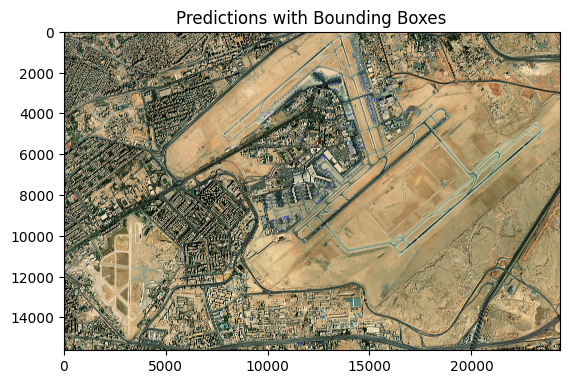

In [20]:
output_image_path = "/kaggle/working/output_image_with_bboxes.tif"
cv2.imwrite(output_image_path, output_image)

output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)

plt.imshow(output_image_rgb)  # No cmap specified for color image
plt.title("Predictions with Bounding Boxes")
plt.show()

In [21]:
import subprocess
from IPython.display import FileLink, display
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [22]:
download_file('/kaggle/working/output_image_with_bboxes_new.tif', 'out')

Unable to run zip command!

